# 2. Ingeniería de características I
## 2.1 Interacción de estudiantes en la plataforma 

In [42]:
import pandas as pd
# --- CARGA Y PREPARACIÓN DE ACTIVIDAD (CLICS) ---

# 1. Cargar datasets procesados
train_interactions = pd.read_csv("../data/processed/training/interactions.csv")
train_students = pd.read_csv("../data/processed/training/students.csv")

# 2. Ingeniería de Identificadores Únicos (Clave Compuesta)
# Un alumno puede estar en varios cursos/presentaciones, son series temporales distintas.
train_interactions['unique_id'] = (train_interactions['id_student'].astype(str) + '_' + 
                                   train_interactions['code_module'] + '_' + 
                                   train_interactions['code_presentation'])

train_students['unique_id'] = (train_students['id_student'].astype(str) + '_' + 
                               train_students['code_module'] + '_' + 
                               train_students['code_presentation'])

# Lista Maestra de Matrículas (Para rellenar huecos después)
all_enrollments = train_students['unique_id'].unique()
print(f"Total de Matrículas únicas a procesar: {len(all_enrollments)}")

# 3. Agregación Semanal Inicial (Pre-Bucketing)
# Convertimos días a semanas (división entera por 7)
train_interactions['week'] = train_interactions['date'] // 7

# Agrupamos por matrícula y semana (sumamos todos los tipos de actividad por ahora)
weekly_clicks = train_interactions.groupby(['unique_id', 'week'])['sum_click'].sum().reset_index()

print("Muestra de Clics Semanales Crudos:")
display(weekly_clicks.head())

Total de Matrículas únicas a procesar: 22785
Muestra de Clics Semanales Crudos:


,unique_id,week,sum_click
0,100064_FFF_2013J,-2,103
1,100064_FFF_2013J,-1,39
2,100064_FFF_2013J,0,190
3,100064_FFF_2013J,1,77
4,100064_FFF_2013J,2,17




### 2.1.1 Transformación Temporal

Para alimentar la arquitectura híbrida descrita en los objetivos, es necesario transformar los datos tabulares de interacción en **series temporales estructuradas**. Esta representación sirve a un doble propósito metodológico:

1.  **Entrada para el Modelo Supervisado (Transformer):** Permite capturar dependencias secuenciales a largo plazo (Objetivo 2.2).
2.  **Base para el Modelo No Supervisado (Clustering):** Proporciona los vectores de comportamiento dinámico necesarios para identificar arquetipos de estudiantes (Objetivo 2.1).

A diferencia de los enfoques tradicionales que agregan la actividad en una única métrica estática (*total clics*), esta fase descompone el comportamiento del estudiante en una secuencia de pasos semanales. Esto permite al modelo capturar la **dinámica evolutiva del aprendizaje**, diferenciando entre un estudiante constante y uno que abandona progresivamente.

**Estrategia de Modelado Temporal:**
Se ha definido una ventana de observación que cubre el ciclo de vida completo del curso, aplicando una estrategia de *Bucketing* para gestionar los extremos temporales sin perder información:

1.  **Resolución Fina (Semanas -2 a 35):** El núcleo del curso se modela con granularidad semanal para detectar patrones precisos de riesgo.
2.  **Agregación de Colas (`Buckets`):**
    *   `w_prev`: Acumula toda la actividad histórica previa a la semana -2 (fase de matrícula y exploración temprana).
    *   `w_post`: Agrupa la actividad remanente tras la semana 35 (cierres administrativos y recuperaciones tardías).


In [43]:

# --- ESTRATEGIA AVANZADA: BUCKETING CORREGIDO ---

# 1. Definimos los límites
WEEK_START = -2
WEEK_END = 35

# 2. Pivotamos (Matriz cruda, solo claves numéricas por ahora)
ts_full = weekly_clicks.groupby(['unique_id', 'week'])['sum_click'].sum().unstack(fill_value=0)

# Aseguramos que las columnas sean floats/ints puros
# A veces Pandas deja nombres raros si hay NaNs en el índice
ts_full.columns = ts_full.columns.astype(float)

# Listamos las columnas disponibles (que son números de semana)
available_weeks = ts_full.columns.tolist()

# 3. Identificamos columnas para cada bucket
cols_prev = [c for c in available_weeks if c < WEEK_START]
cols_core = [c for c in available_weeks if WEEK_START <= c <= WEEK_END]
cols_post = [c for c in available_weeks if c > WEEK_END]

# 4. Construimos el nuevo DataFrame paso a paso
ts_buckets = pd.DataFrame(index=ts_full.index)

# Bucket Previo
ts_buckets['w_prev'] = ts_full[cols_prev].sum(axis=1) if cols_prev else 0

# Núcleo Central (copiamos tal cual)
for c in cols_core:
    col_name = f'w_{int(c)}' if c >= 0 else f'w_neg{abs(int(c))}'
    ts_buckets[col_name] = ts_full[c]

# Bucket Posterior
ts_buckets['w_post'] = ts_full[cols_post].sum(axis=1) if cols_post else 0

# 5. Reindexar con todos los estudiantes (recuperar inactivos)
ts_clicks = ts_buckets.reindex(all_enrollments, fill_value=0)

print(f"Matriz Final con Buckets: {ts_clicks.shape}")
print("Columnas:", list(ts_clicks.columns[:5]) + ["..."] + list(ts_clicks.columns[-5:]))
display(ts_clicks.sample(5))

Matriz Final con Buckets: (22785, 40)
Columnas: ['w_prev', 'w_neg2', 'w_neg1', 'w_0', 'w_1', '...', 'w_32', 'w_33', 'w_34', 'w_35', 'w_post']


,w_prev,w_neg2,w_neg1,w_0,w_1,w_2,w_3,w_4,w_5,w_6,...,w_27,w_28,w_29,w_30,w_31,w_32,w_33,w_34,w_35,w_post
unique_id,,,,,,,,,,,,,,,,,,,,,
575207_BBB_2013J,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
630730_CCC_2014B,0,0,4,12,33,263,12,30,27,30,...,180,0,302,45,1,49,0,0,0,0
395288_DDD_2014B,0,0,0,11,15,0,0,3,0,0,...,0,35,0,0,0,56,1,0,0,0
626198_FFF_2014B,48,1,7,90,16,66,10,17,40,45,...,7,0,165,89,212,335,0,0,0,0
686913_EEE_2014J,0,6,20,6,161,0,0,78,0,0,...,0,0,6,0,0,0,25,0,0,0


### 2.1.2 **Justificación Técnica: Bucketing Logarítmico**

Tras la generación de la matriz temporal, se observa que la distribución de la actividad sigue una **Ley de Potencia** (Power Law): la mayoría de estudiantes genera pocos clics semanales, mientras que una minoría ("power users") genera miles.

Esta dispersión extrema dificulta la convergencia de las redes neuronales, cuyos gradientes son sensibles a las magnitudes de entrada. Para mitigar este problema sin eliminar la información de los valores altos, se aplica una transformación no lineal:

$$ x' = \log(1 + x) $$

**Resultados de la Transformación:**
*   **Compresión de Rango:** La escala original [0, ~7000] se reduce a un espacio denso [0, ~9.0], mucho más amigable para el entrenamiento.
*   **Normalización de Distribución:** Se suaviza el sesgo (skewness) de la distribución, acercándola a una normalidad que favorece el aprendizaje de los pesos en las capas de atención del Transformer.


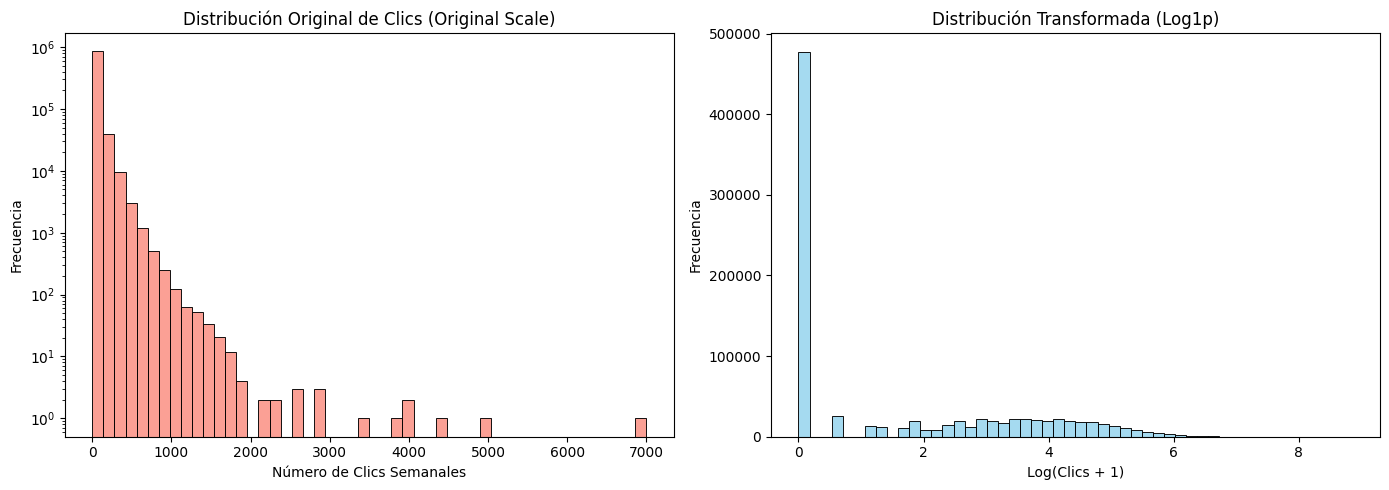

Estadísticas tras transformación:
Mínimo: 0.0
Máximo: 8.85 (Equivalente a 6999 clics reales)


In [44]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Aplicamos Logaritmo (log1p para manejar ceros de forma segura: log(x+1))
ts_clicks_log = np.log1p(ts_clicks)

# 2. Visualización Comparativa: ¿Por qué hicimos esto?
plt.figure(figsize=(14, 5))

# Gráfico A: Datos Originales (Muy sesgados)
plt.subplot(1, 2, 1)
# Aplanamos la matriz para ver la distribución global de clics
sns.histplot(ts_clicks.values.flatten(), bins=50, color='salmon')
plt.title("Distribución Original de Clics (Original Scale)")
plt.xlabel("Número de Clics Semanales")
plt.ylabel("Frecuencia")
plt.yscale('log') # Escala log en Y para ver algo, si no sería una sola barra

# Gráfico B: Datos Logarítmicos (Distribución casi Normal)
plt.subplot(1, 2, 2)
sns.histplot(ts_clicks_log.values.flatten(), bins=50, color='skyblue')
plt.title("Distribución Transformada (Log1p)")
plt.xlabel("Log(Clics + 1)")
plt.ylabel("Frecuencia")

plt.tight_layout()
plt.show()

print("Estadísticas tras transformación:")
print(f"Mínimo: {ts_clicks_log.min().min()}")
print(f"Máximo: {ts_clicks_log.max().max():.2f} (Equivalente a {np.expm1(ts_clicks_log.max().max()):.0f} clics reales)")

In [45]:
# 1. Aplicamos la transformación logarítmica definitiva
# Reemplazamos los valores crudos por log(x+1)
try:
    if 'ts_clicks_log' in locals():
        del ts_clicks_log # Limpiamos memoria
    ts_clicks = np.log1p(ts_clicks)
    print("Transformación Log1p aplicada a la matriz temporal principal.")
except Exception as e:
    print(f"Error al transformar: {e}")

# 2. Extracción de la Variable Objetivo (Target) alineada
# Necesitamos saber si cada fila de 'ts_clicks' aprobó o no.
# Usamos 'unique_id' para cruzar correctamente.

# Nos aseguramos que train_students tenga el índice correcto
if 'unique_id' in train_students.columns:
    train_students.set_index('unique_id', inplace=True)

# Alineamos y extraemos target
# .loc[ts_clicks.index] garantiza que el orden sea IDÉNTICO al de la matriz temporal
y_target = train_students.loc[ts_clicks.index, 'final_result']

# Convertimos target a numérico (Multiclase)
# Mapping: Distinction=3, Pass=2, Fail=1, Withdrawn=0 (Orden de éxito)
target_map = {'Distinction': 3, 'Pass': 2, 'Fail': 1, 'Withdrawn': 0}
y_encoded = y_target.map(target_map)

print("\nShape de Features Temporales:", ts_clicks.shape)
print("Shape del Target Alineado:", y_encoded.shape)
print("\nPrimeros 5 targets codificados:")
print(y_encoded.head())
ts_clicks.head()

Transformación Log1p aplicada a la matriz temporal principal.

Shape de Features Temporales: (22785, 40)
Shape del Target Alineado: (22785,)

Primeros 5 targets codificados:
unique_id
11391_AAA_2013J    2
28400_AAA_2013J    2
32885_AAA_2013J    2
45462_AAA_2013J    2
45642_AAA_2013J    2
Name: final_result, dtype: int64


,w_prev,w_neg2,w_neg1,w_0,w_1,w_2,w_3,w_4,w_5,w_6,...,w_27,w_28,w_29,w_30,w_31,w_32,w_33,w_34,w_35,w_post
unique_id,,,,,,,,,,,,,,,,,,,,,
11391_AAA_2013J,0.0,0.000000,4.595120,5.214936,3.044522,4.615121,0.000000,3.295837,4.110874,3.135494,...,1.945910,0.000000,0.000000,3.784190,3.583519,0.000000,2.772589,4.454347,2.079442,0.693147
28400_AAA_2013J,0.0,4.382027,4.919981,5.170484,4.204693,3.637586,4.060443,4.330733,0.000000,3.091042,...,4.584967,2.197225,3.091042,4.488636,1.791759,2.564949,0.000000,0.693147,0.000000,0.000000
32885_AAA_2013J,0.0,4.584967,5.293305,4.127134,4.762174,3.637586,4.077537,2.944439,2.833213,0.000000,...,1.386294,0.000000,1.945910,0.000000,4.094345,3.332205,3.258097,1.386294,2.079442,0.000000
45462_AAA_2013J,0.0,4.304065,4.682131,4.317488,0.000000,5.252273,4.025352,4.718499,3.401197,2.564949,...,3.258097,2.639057,4.007333,3.970292,0.000000,0.000000,0.000000,4.820282,0.000000,1.609438
45642_AAA_2013J,0.0,2.197225,2.639057,3.367296,4.304065,5.220356,4.644391,3.761200,4.248495,2.639057,...,2.639057,0.000000,2.772589,3.258097,3.637586,4.488636,4.595120,2.197225,2.302585,2.564949



### **2.1.3 Desglose Temporal por Tipo de Actividad (Enfoque Multicanal)**

El análisis exploratorio reveló diferencias significativas en los patrones de navegación entre estudiantes exitosos y aquellos en riesgo. Mientras que el volumen total de clics (`sum_click`) es un indicador de intensidad, la **distribución de la atención** ofrece una señal de calidad pedagógica.

Para capturar esta dimensión cualitativa, se extiende la matriz temporal base generando **canales de actividad independientes** que alimentarán al modelo Autoencoder/Transformer como una entrada multivariante:

*   **Canal `Generic Content` (Estudio Pasivo):** Agrega la interacción con materiales estáticos (`oucontent`, `resource`, `page`, `url`). Indica consumo básico de temario.
*   **Canal `Forum` (Aprendizaje Social):** Captura la actividad en `forumng`. Un indicador clave de búsqueda de ayuda y colaboración entre pares.
*   **Canal `Quiz` (Autoevaluación):** Registra el uso de `quiz` y cuestionarios. Refleja estrategias de aprendizaje activo y preparación para exámenes.

Esta descomposición permite al modelo detectar perfiles específicos, como el "Lurker" (mucho contenido, poco foro) o el "Examinee" (solo quizzes antes de fechas límite).

---


In [46]:
# --- 4.1. INGENIERÍA DE CARACTERÍSTICAS MULTICANAL (ACTIVIDAD) ---

# 1. Definimos los Canales de Interés (Basado en el EDA)
# Agrupamos tipos similares para simplificar y reducir ruido
activity_map = {
    'content': ['oucontent', 'resource', 'url', 'page', 'subpage'], # Estudio pasivo
    'social': ['forumng', 'oucollaborate', 'ouwiki'],               # Aprendizaje social
    'quiz': ['quiz', 'questionnaire'],                              # Autoevaluación
    'other': [] # El resto irá aquí (homepage, glossary, etc.)
}

# 2. Función Helper para Bucketing (Reutilizable y limpia)
def generate_channel_matrix(df_source, channel_name, target_types=None):
    """Genera una matriz temporal bucketeada para un subconjunto de actividades."""
    
    # Filtrar
    if target_types:
        df_sub = df_source[df_source['activity_type'].isin(target_types)]
    else:
        # Calcular 'otros': Todo lo que NO está en los mapas anteriores
        all_mapped = sum(activity_map.values(), [])
        df_sub = df_source[~df_source['activity_type'].isin(all_mapped)]

    # Pivotar (Semanas)
    ts_pivot = df_sub.groupby(['unique_id', 'week'])['sum_click'].sum().unstack(fill_value=0)
    
    # Bucketing Logic (Igual que antes)
    ts_out = pd.DataFrame(index=ts_pivot.index)
    available_weeks = ts_pivot.columns
    
    # Prev (< -2)
    cols_prev = [c for c in available_weeks if c < -2]
    ts_out[f'{channel_name}_prev'] = ts_pivot[cols_prev].sum(axis=1) if cols_prev else 0
    
    # Core (-2 a 35)
    for w in range(-2, 36): # Range va hasta 36 para incluir el 35
        if w in available_weeks:
            col_name = f'{channel_name}_w_{w}' if w >= 0 else f'{channel_name}_w_neg{abs(w)}'
            ts_out[col_name] = ts_pivot[w]
        else:
            col_name = f'{channel_name}_w_{w}' if w >= 0 else f'{channel_name}_w_neg{abs(w)}'
            ts_out[col_name] = 0 # Rellenar semanas vacías
            
    # Post (> 35)
    cols_post = [c for c in available_weeks if c > 35]
    ts_out[f'{channel_name}_post'] = ts_pivot[cols_post].sum(axis=1) if cols_post else 0
    
    return ts_out

# 3. Generar Matrices
print("Generando canales de actividad...")
channels_list = []

# Canales principales
for name, types in activity_map.items():
    print(f"  - Procesando canal: {name} ({len(types)} tipos)...")
    matrix = generate_channel_matrix(train_interactions, name, types)
    # Reindexar para asegurar alineación con estudiantes
    matrix = matrix.reindex(all_enrollments, fill_value=0)
    channels_list.append(matrix)

# Canal 'other' (lo que sobra)
# matrix_other = generate_channel_matrix(train_interactions, 'other', None) 
# channels_list.append(matrix_other.reindex(all_enrollments, fill_value=0))

# 4. Concatenar y Log-Transform
ts_multichannel = pd.concat(channels_list, axis=1)
ts_multichannel_log = np.log1p(ts_multichannel)

print(f"\nMatriz Multicanal Generada: {ts_multichannel_log.shape}")
display(ts_multichannel_log.head())

Generando canales de actividad...
  - Procesando canal: content (5 tipos)...
  - Procesando canal: social (3 tipos)...
  - Procesando canal: quiz (2 tipos)...
  - Procesando canal: other (0 tipos)...

Matriz Multicanal Generada: (22785, 160)


,content_prev,content_w_neg2,content_w_neg1,content_w_0,content_w_1,content_w_2,content_w_3,content_w_4,content_w_5,content_w_6,...,other_w_27,other_w_28,other_w_29,other_w_30,other_w_31,other_w_32,other_w_33,other_w_34,other_w_35,other_post
unique_id,,,,,,,,,,,,,,,,,,,,,
11391_AAA_2013J,0.0,0.000000,4.499810,4.962845,2.995732,4.007333,0.000000,2.708050,3.465736,0.000000,...,1.098612,0.000000,0.000000,2.397895,1.098612,0.000000,0.693147,1.609438,1.098612,0.693147
28400_AAA_2013J,0.0,3.850148,3.931826,4.189655,3.135494,2.564949,3.433987,4.007333,0.000000,0.000000,...,3.218876,1.386294,1.098612,2.397895,1.098612,1.609438,0.000000,0.693147,0.000000,0.000000
32885_AAA_2013J,0.0,4.234107,4.615121,2.079442,4.510860,2.890372,3.784190,2.772589,2.708050,0.000000,...,0.693147,0.000000,1.098612,0.000000,2.772589,1.386294,1.791759,1.098612,1.386294,0.000000
45462_AAA_2013J,0.0,4.043051,4.343805,3.970292,0.000000,4.976734,3.465736,4.276666,2.639057,1.386294,...,1.791759,1.386294,2.397895,2.944439,0.000000,0.000000,0.000000,3.044522,0.000000,1.609438
45642_AAA_2013J,0.0,0.693147,1.098612,2.995732,3.258097,4.418841,3.637586,2.397895,3.044522,1.098612,...,1.386294,0.000000,1.098612,1.609438,2.197225,3.044522,2.772589,1.609438,1.386294,1.386294


## 2.2 Entrega de actividades 

### 2.2.1 Distribución temporal de actividades por tipo de actividad

Previo a la generación de las características de rendimiento, es necesario realizar una auditoría temporal de los tipos de evaluación disponibles en el conjunto de datos (TMA, CMA, Exam). El objetivo de este análisis es confirmar si los exámenes finales ocurren simultáneamente al periodo lectivo o si, por el contrario, representan un hito post-instruccional que debe ser excluido para evitar la filtración de datos futuros (data leakage) en el modelo predictivo.

C:\Users\maike\AppData\Local\Temp\ipykernel_21000\2994117022.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='assessment_type', y=target_date, data=train_assessments, palette='viridis')


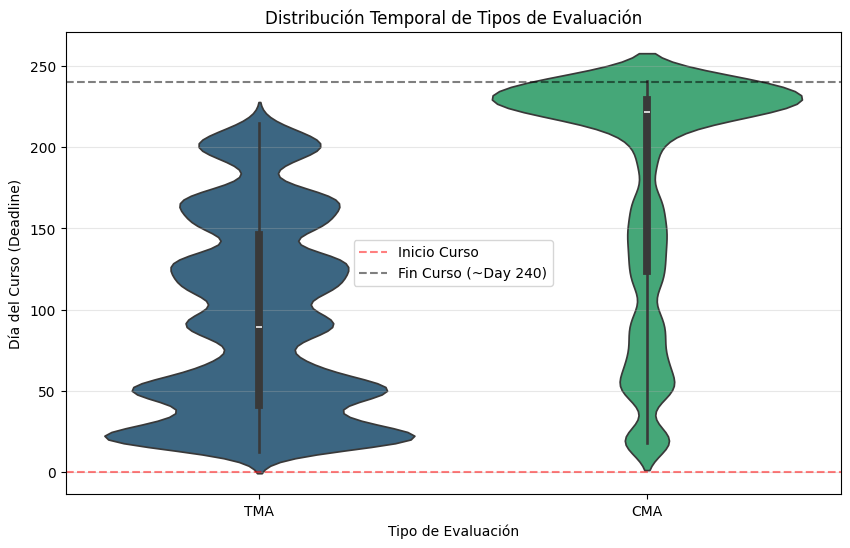

Resumen de Fechas (Días) por Tipo:
                  min        mean    max    count
assessment_type                                  
CMA              18.0  177.041770  241.0  49437.0
TMA              12.0   94.726719  215.0  68640.0


In [47]:

import matplotlib.pyplot as plt
import seaborn as sns

# Usamos la columna 'date' (fecha deadline oficial) si existe, o 'date_submitted'
if 'date' in train_assessments.columns:
    target_date = 'date'
else:
    target_date = 'date_submitted' # Fallback si no está la oficial

# Gráfico de violín para ver la distribución temporal
plt.figure(figsize=(10, 6))
sns.violinplot(x='assessment_type', y=target_date, data=train_assessments, palette='viridis')
plt.title("Distribución Temporal de Tipos de Evaluación")
plt.ylabel("Día del Curso (Deadline)")
plt.xlabel("Tipo de Evaluación")
plt.grid(axis='y', alpha=0.3)

# Dibujar líneas de referencia (Semana 0 y Semana 35)
plt.axhline(0, color='r', linestyle='--', alpha=0.5, label='Inicio Curso')
plt.axhline(240, color='k', linestyle='--', alpha=0.5, label='Fin Curso (~Day 240)')
plt.legend()
plt.show()

# Estadísticas descriptivas
print("Resumen de Fechas (Días) por Tipo:")
print(train_assessments.groupby('assessment_type')[target_date].describe()[['min', 'mean', 'max', 'count']])

### **5.2.2. Prevención de Data Leakage: exclusión de exámenes finales**

Para garantizar la validez del modelo predictivo de "Riesgo Temprano", es imperativo segregar las señales de proceso de las señales de resultado.

El análisis de la distribución temporal de las evaluaciones (`assessment_type`) revela un patrón claro:
*   **TMA (Tutor Marked Assessments) y CMA (Computer Marked Assessments):** Se distribuyen a lo largo de todo el curso, actuando como hitos de progreso continuo. Son variables predictoras legítimas ($X$).
*   **Exam:** Se concentran exclusivamente en la semana final del curso (Día > 240).

**Decisión de Diseño:**
Se excluyen sistemáticamente los registros de tipo `Exam` del tensor de entrada temporal. Incluirlos introduciría un **Data Leakage** severo, ya que la presencia de una nota de examen final implica implícitamente que el estudiante ha completado el curso, trivializando la tarea de predicción y anulando la capacidad del modelo para operar en tiempo real durante las semanas lectivas.

### Diferentes métricas

La evaluación del estudiante no debe limitarse a una instantánea puntual. Para el modelo predictivo, es crucial entender la evolución del rendimiento y el compromiso a lo largo del tiempo. Se ha diseñado un tensor de entrada multidimensional que captura tres señales complementarias para cada semana del curso:

1.  **Nivel de Competencia (`avg_score`):** Promedio acumulado de calificaciones hasta la fecha. Esta métrica suavizada (Running Average) elimina la dispersión de los datos crudos y ofrece al modelo una visión continua del desempeño actual del alumno.
2.  **Índice de Compromiso (`submission_rate`):** Tasa normalizada de entregas realizadas. Permite detectar el "abandono silencioso" (estudiantes que dejan de entregar tareas antes de formalizar su baja) independientemente de sus notas.
3.  **Tendencia de Rendimiento (`score_trend`):** Diferencial entre la última calificación obtenida y el promedio histórico del alumno. Esta señal de "momentum" ayuda a la red neuronal a identificar cambios bruscos de trayectoria (mejoras o empeoramientos repentinos).

**Implicación Metodológica:**
Esta estrategia expande la dimensionalidad temporal del modelo híbrido. En lugar de una simple serie temporal univariante, el Transformer procesará una secuencia multivariante (Multivariate Time Series), permitiendo mecanismos de atención más ricos que correlacionen, por ejemplo, una caída en la *Tasa de Entregas* con una bajada previa en la *Tendencia de Rendimiento*.

In [48]:
# --- 5. INGENIERÍA DE CARACTERÍSTICAS III: RENDIMIENTO DESGLOSADO (TMA vs CMA) ---

# 1. Preparación de Datos
# Recargamos para asegurar limpieza, aunque podrías usar el df en memoria si confías
df_assessments = pd.read_csv("../data/processed/training/assessments.csv")

# A. FILTRO CRÍTICO: Excluir Exámenes Finales (Data Leakage)
df_assessments = df_assessments[df_assessments['assessment_type'] != 'Exam']

# B. Generar claves
df_assessments['unique_id'] = (df_assessments['id_student'].astype(str) + '_' + 
                               df_assessments['code_module'] + '_' + 
                               df_assessments['code_presentation'])
df_assessments['week'] = (df_assessments['date_submitted'] // 7).astype(int)

# 2. Configuración de Canales de Evaluación
# Definimos qué tipos queremos tratar por separado
assessment_channels = ['TMA', 'CMA'] # Tutor Marked vs Computer Marked

# Función para generar matriz de rendimiento por tipo
def get_performance_matrix(df, assess_type):
    # Filtrar por tipo
    df_type = df[df['assessment_type'] == assess_type].copy()
    
    # Pivotar (Scores)
    ts_pivot = df_type.groupby(['unique_id', 'week'])['score'].mean().unstack(fill_value=-1)
    ts_pivot.columns = ts_pivot.columns.astype(float)
    
    # --- BUCKETING LOGIC (Idéntica a Clics) ---
    WEEK_START, WEEK_END = -2, 35
    available_weeks = sorted(ts_pivot.columns.tolist())
    cols_prev = [c for c in available_weeks if c < WEEK_START]
    cols_core = [c for c in available_weeks if WEEK_START <= c <= WEEK_END]
    cols_post = [c for c in available_weeks if c > WEEK_END]
    
    ts_buckets = pd.DataFrame(index=ts_pivot.index)
    
    # Bucket Prev
    ts_buckets[f'{assess_type}_w_prev'] = ts_pivot[cols_prev].replace(-1, np.nan).mean(axis=1).fillna(-1) if cols_prev else -1
    
    # Bucket Core
    for c in range(WEEK_START, WEEK_END + 1):
        if c in ts_pivot.columns:
            col_name = f'{assess_type}_w_{c}' if c >= 0 else f'{assess_type}_w_neg{abs(c)}'
            ts_buckets[col_name] = ts_pivot[c]
        else:
            col_name = f'{assess_type}_w_{c}' if c >= 0 else f'{assess_type}_w_neg{abs(c)}'
            ts_buckets[col_name] = -1 # Relleno para semanas sin ese tipo de examen
            
    # Bucket Post
    ts_buckets[f'{assess_type}_w_post'] = ts_pivot[cols_post].replace(-1, np.nan).mean(axis=1).fillna(-1) if cols_post else -1
    
    # Reindexar con todos los alumnos (para rellenar los que no tienen este tipo de nota con -1)
    ts_final = ts_buckets.reindex(all_enrollments, fill_value=-1)
    
    return ts_final

# 3. Generación y Cálculo de Métricas Derivadas
performance_matrices = []

for channel in assessment_channels:
    print(f"Procesando canal de evaluación: {channel}...")
    
    # A. Obtener Matriz Base (Notas crudas con buckets, -1 = no entregado)
    ts_base = get_performance_matrix(df_assessments, channel)
    ts_raw = ts_base.replace(-1, np.nan) # Convertir -1 a NaN para cálculos
    cols = ts_base.columns
    
    # B. Feature 1: Promedio Acumulado (Running Average)
    # Rellenamos nulos con el promedio anterior (forward fill)
    feat_avg = ts_raw.T.expanding().mean().T.fillna(0) / 100.0
    feat_avg.columns = [c.replace(f'{channel}_', f'{channel}_avg_') for c in cols]
    
    # C. Feature 2: Tasa de Entrega (Submission Rate)
    # 1 si entregó, 0 si no
    is_submitted = (~ts_raw.isna()).astype(int) 
    # Acumulado de entregas / Total posible hasta la fecha
    feat_rate = is_submitted.T.cumsum().T
    # Normalizamos por el máximo de entregas vistas en esa semana (para evitar división por cero en semanas vacías)
    max_possible = feat_rate.max() 
    feat_rate = feat_rate.div(max_possible.replace(0, 1), axis=1)
    feat_rate.columns = [c.replace(f'{channel}_', f'{channel}_rate_') for c in cols]
    
    # D. Feature 3: Tendencia (Score Trend)
    # Nota actual - Promedio histórico (0 si no entregó)
    trend_vals = (ts_raw.fillna(0).values - (feat_avg.values * 100)) / 100.0
    feat_trend = pd.DataFrame(trend_vals, index=ts_base.index, 
                              columns=[c.replace(f'{channel}_', f'{channel}_trend_') for c in cols])
    
    # Concatenar features de este canal
    performance_matrices.extend([feat_avg, feat_rate, feat_trend])

# 4. Consolidación Final
ts_performance_multichannel = pd.concat(performance_matrices, axis=1)

print(f"\nMatriz de Rendimiento Multicanal: {ts_performance_multichannel.shape}")
display(ts_performance_multichannel.head())

Procesando canal de evaluación: TMA...
Procesando canal de evaluación: CMA...

Matriz de Rendimiento Multicanal: (22785, 240)


,TMA_avg_w_prev,TMA_avg_w_neg2,TMA_avg_w_neg1,TMA_avg_w_0,TMA_avg_w_1,TMA_avg_w_2,TMA_avg_w_3,TMA_avg_w_4,TMA_avg_w_5,TMA_avg_w_6,...,CMA_trend_w_27,CMA_trend_w_28,CMA_trend_w_29,CMA_trend_w_30,CMA_trend_w_31,CMA_trend_w_32,CMA_trend_w_33,CMA_trend_w_34,CMA_trend_w_35,CMA_trend_w_post
unique_id,,,,,,,,,,,,,,,,,,,,,
11391_AAA_2013J,0.0,0.0,0.0,0.0,0.0,0.78,0.78,0.78,0.78,0.78,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28400_AAA_2013J,0.0,0.0,0.0,0.0,0.0,0.00,0.70,0.70,0.70,0.70,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32885_AAA_2013J,0.0,0.0,0.0,0.0,0.0,0.00,0.69,0.69,0.69,0.69,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
45462_AAA_2013J,0.0,0.0,0.0,0.0,0.0,0.70,0.70,0.70,0.70,0.70,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
45642_AAA_2013J,0.0,0.0,0.0,0.0,0.0,0.72,0.72,0.72,0.72,0.72,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [49]:
# 1. Asignamos el tensor multicanal a la variable estándar que usaremos
ts_performance = ts_performance_multichannel

# 2. Inspección del alumno (CÓDIGO CORREGIDO)
# Cogemos un alumno de ejemplo (el segundo del índice)
alumno_id = ts_performance.index[1] 

# Filtramos las columnas de la Semana 4 para ver TMA vs CMA
cols_semana_4 = [c for c in ts_performance.columns if '_w_4' in c]

print(f"Datos del alumno {alumno_id} en la Semana 4 (TMA vs CMA):")
print(ts_performance.loc[alumno_id, cols_semana_4])

Datos del alumno 28400_AAA_2013J en la Semana 4 (TMA vs CMA):
TMA_avg_w_4      0.700000
TMA_rate_w_4     0.333333
TMA_trend_w_4   -0.700000
CMA_avg_w_4      0.000000
CMA_rate_w_4     0.000000
CMA_trend_w_4    0.000000
Name: 28400_AAA_2013J, dtype: float64


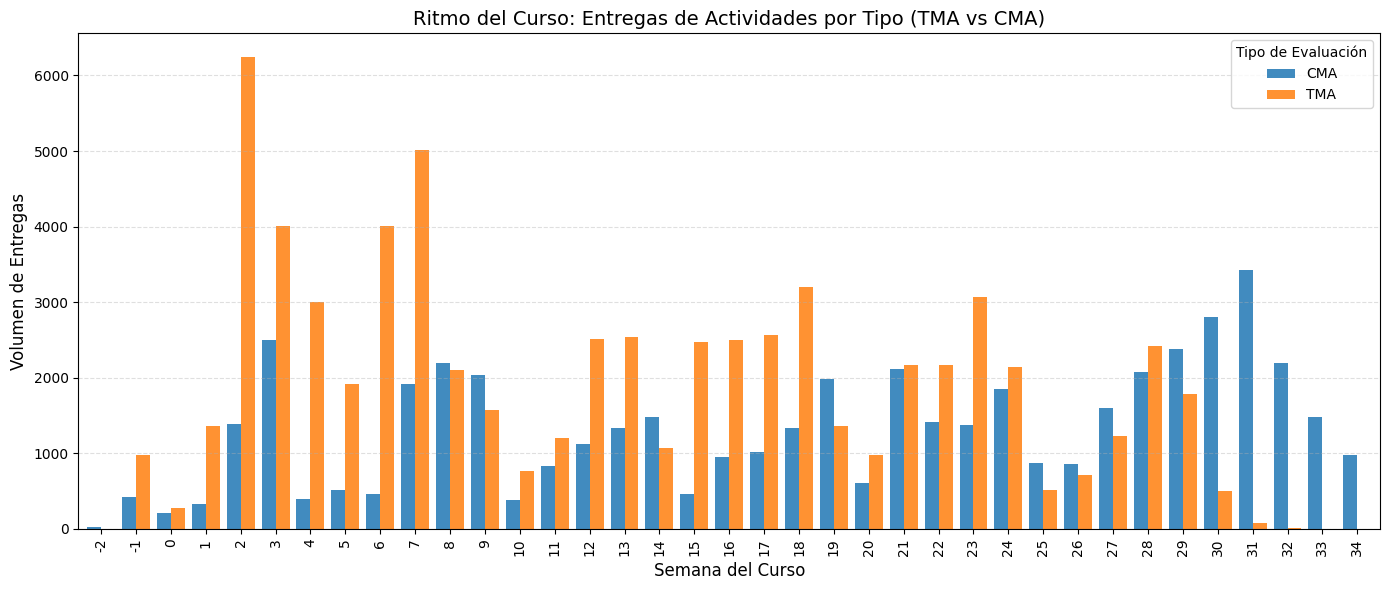

Semanas críticas (Solo TMA - Carga Alta par el tutor): []


In [50]:
# --- AUDITORÍA VISUAL AVANZADA: TMA vs CMA POR SEMANA ---
import matplotlib.pyplot as plt
import pandas as pd

# 1. Preparamos los datos
# Agrupamos por Semana Y por Tipo de Evaluación
counts_by_type = df_assessments.groupby(['week', 'assessment_type']).size().unstack(fill_value=0)

# Filtramos el rango de semanas relevante para el curso (-2 a 35)
counts_by_type = counts_by_type.loc[-2:35]

# 2. Generamos el Gráfico de Barras Agrupadas
# Pandas lo hace automático con kind='bar' si el índice es la semana y las columnas son los tipos
ax = counts_by_type.plot(kind='bar', figsize=(14, 6), width=0.8, alpha=0.85)

# 3. Personalización "Pro"
plt.title("Ritmo del Curso: Entregas de Actividades por Tipo (TMA vs CMA)", fontsize=14)
plt.xlabel("Semana del Curso", fontsize=12)
plt.ylabel("Volumen de Entregas", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.legend(title='Tipo de Evaluación')

# Rotamos etiquetas para leer bien las semanas
plt.xticks(rotation=0 if len(counts_by_type) < 15 else 90)

plt.tight_layout()
plt.show()

# Extra: Ver semanas de "solo TMA" (picos de carga alta)
solo_tma_weeks = counts_by_type[(counts_by_type['CMA'] == 0) & (counts_by_type['TMA'] > 0)].index.tolist()
print("Semanas críticas (Solo TMA - Carga Alta par el tutor):", solo_tma_weeks)

In [51]:
# --- ENGINEERING ADD-ON: CRÉDITOS CONVALIDADOS (is_banked) ---

# Agrupamos por matrícula para ver si tiene alguna nota convalidada
# is_banked suele ser 1 si es convalidada.
banked_counts = train_assessments.groupby('unique_id')['is_banked'].sum()

# Convertimos a DataFrame para alinear
df_banked = pd.DataFrame(banked_counts).reindex(all_enrollments, fill_value=0)
df_banked.columns = ['transfer_credits']  # Nombre más académico

print("Distribución de Créditos Convalidados:")
print(df_banked['transfer_credits'].value_counts().head())
# Guardamos df_banked para unirlo luego a X_static

Distribución de Créditos Convalidados:
transfer_credits
0    22531
2       48
3       46
4       42
1       40
Name: count, dtype: int64


# --- 5.3 Factores Psicológicos y de Contexto (Nuevas Features) ---

Siguiendo las mejores prácticas en psicometría educativa y detección de riesgo temprano, incorporamos variables que capturan la "personalidad" del estudiante y el contexto del curso:

1.  **Factor Procrastinación (`days_early`):**
    *   Calculado como $ \text{Fecha Límite} - \text{Fecha Entrega} $.
    *   **Valores positivos:** Entrega anticipada (Planificación).
    *   **Valores negativos:** Entrega tardía (Riesgo).
    *   **Cero:** Entrega al límite.
    *   Se modela como serie temporal para ver si el estudiante "se deja ir" con el tiempo.

2.  **Factor Regularidad (`click_std`):**
    *   Desviación estándar de la actividad semanal.
    *   Distingue entre estudiantes constantes (baja varianza) y estudiantes de "atracón" (alta varianza).


In [56]:
# --- ENGINEERING: FACTOR PROCRASTINACIÓN (DAYS_EARLY) ---

print("Generando Canal de Procrastinación (Days Early)...")

# 1. Calcular 'days_early' (Delta de entrega)
# CORRECCIÓN DE SEGURIDAD: Eliminamos evaluaciones sin fecha límite definida
ts_assess_delta = df_assessments.dropna(subset=['date']).copy()

# Aseguramos tipos numéricos para poder restar
ts_assess_delta['date'] = pd.to_numeric(ts_assess_delta['date'], errors='coerce')
ts_assess_delta['date_submitted'] = pd.to_numeric(ts_assess_delta['date_submitted'], errors='coerce')

# Cálculo del delta: Positivo = Anticipación, Negativo = Retraso
ts_assess_delta['days_early'] = ts_assess_delta['date'] - ts_assess_delta['date_submitted']

# 2. Pivotar para crear serie temporal (Promedio por semana si hay varias entregas)
# Usamos -999 como placeholder temporal de "no entrega" para distinguirlo del 0 (entrega on-time)
ts_procrastination = ts_assess_delta.groupby(['unique_id', 'week'])['days_early'].mean().unstack(fill_value=-999)

# 3. Aplicar Bucketing (Semana -2 a 35)
ts_proc_buckets = pd.DataFrame(index=ts_procrastination.index)
available_weeks_proc = sorted(ts_procrastination.columns.tolist())

# Definir límites
WEEK_START, WEEK_END = -2, 35
cols_prev = [c for c in available_weeks_proc if c < WEEK_START]
cols_core = [c for c in available_weeks_proc if WEEK_START <= c <= WEEK_END]
cols_post = [c for c in available_weeks_proc if c > WEEK_END]

# Bucket Prev (Promedio)
ts_proc_buckets['proc_avg_w_prev'] = ts_procrastination[cols_prev].replace(-999, np.nan).mean(axis=1).fillna(0) if cols_prev else 0

# Bucket Core
for c in range(WEEK_START, WEEK_END + 1):
    col_name = f'proc_w_{c}' if c >= 0 else f'proc_w_neg{abs(c)}'
    if c in ts_procrastination.columns:
        # Reemplazamos el placeholder -999 por 0.
        # Nota de Diseño:
        # 0 significa AHORA dos cosas: "Entrega al límite" O "Sin Tarea".
        # Esto es aceptable en una arquitectura híbrida porque el canal de Rendimiento (Scores)
        # desambiguará: si Score != 0, entonces ese 0 es "Entrega al límite".
        ts_proc_buckets[col_name] = ts_procrastination[c].replace(-999, 0)
    else:
        ts_proc_buckets[col_name] = 0

# Bucket Post
ts_proc_buckets['proc_avg_w_post'] = ts_procrastination[cols_post].replace(-999, np.nan).mean(axis=1).fillna(0) if cols_post else 0

# Reindexar para tener a todos los alumnos (los que no tienen entregas tendrán todo 0)
ts_days_early = ts_proc_buckets.reindex(all_enrollments, fill_value=0)

print(f"Matriz de Procrastinación creada: {ts_days_early.shape}")
display(ts_days_early.head(20))

Generando Canal de Procrastinación (Days Early)...
Matriz de Procrastinación creada: (22785, 40)


,proc_avg_w_prev,proc_w_neg2,proc_w_neg1,proc_w_0,proc_w_1,proc_w_2,proc_w_3,proc_w_4,proc_w_5,proc_w_6,...,proc_w_27,proc_w_28,proc_w_29,proc_w_30,proc_w_31,proc_w_32,proc_w_33,proc_w_34,proc_w_35,proc_avg_w_post
unique_id,,,,,,,,,,,,,,,,,,,,,
11391_AAA_2013J,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0,0.0
28400_AAA_2013J,0,0.0,0.0,0.0,0.0,0.0,-3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0,0.0
32885_AAA_2013J,0,0.0,0.0,0.0,0.0,0.0,-7.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-7.0,0.0,0.0,0.0,0,0.0
45462_AAA_2013J,0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0,0.0
45642_AAA_2013J,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-12.0,0.0,0.0,0,0.0
53025_AAA_2013J,0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0,0.0
57506_AAA_2013J,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0.0
58873_AAA_2013J,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0
62155_AAA_2013J,0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0,0.0


In [59]:
# --- ENGINEERING: FACTORES ESTÁTICOS Y REGULARIDAD (FINAL) ---

print("Procesando Features Estáticas, Demográficas y de Varianza...")

# A. REGULARIDAD (Varianza de Clics)
click_std = ts_clicks.std(axis=1)
click_std.name = 'click_std'

# B. RECUPERACIÓN DE DATOS (Tu bloque robusto)
df_temp = train_students.copy()

if 'unique_id' not in df_temp.columns:
    if df_temp.index.name == 'unique_id':
        df_temp = df_temp.reset_index()
    else:
        df_temp['unique_id'] = (df_temp['id_student'].astype(str) + '_' + 
                                df_temp['code_module'] + '_' + 
                                df_temp['code_presentation'])

# --- AQUÍ AÑADIMOS LAS COLUMNAS QUE FALTABAN ---
cols_needed = [
    'unique_id', 'code_module', 'credits', 'module_presentation_length', 
    'date_registration', 'imd_band', 'num_of_prev_attempts',
    'disability', 'highest_education', 'gender', 'age_band' # <--- NUEVAS
]

cols_exist = [c for c in cols_needed if c in df_temp.columns]
df_static = df_temp[cols_exist].set_index('unique_id').copy()

# 1. IMD Band (Socioeconómico)
imd_map = {
    '0-10%': 0, '10-20%': 1, '20-30%': 2, '30-40%': 3, '40-50%': 4,
    '50-60%': 5, '60-70%': 6, '70-80%': 7, '80-90%': 8, '90-100%': 9,
    'Unknown': -1
}
# Nota: A veces OULAD usa '10-20' sin el %. El .map lo gestionará, pero revisa tus unique().
if 'imd_band' in df_static.columns:
    df_static['imd_band_numeric'] = df_static['imd_band'].map(imd_map).fillna(-1)

# 2. Créditos y Duración
if 'credits' in df_static.columns:
    df_static['credits'] = pd.to_numeric(df_static['credits'], errors='coerce').fillna(0)

df_static['module_presentation_length'] = pd.to_numeric(df_static['module_presentation_length'], errors='coerce')

# 3. Code Module (Dominio: 0=Social, 1=STEM)
domain_map = {'AAA': 0, 'BBB': 0, 'GGG': 0, 'CCC': 1, 'DDD': 1, 'EEE': 1, 'FFF': 1}
df_static['course_domain'] = df_static['code_module'].map(domain_map).fillna(0)

# ---------------------------------------------------------
# D. DEMOGRÁFICOS CRÍTICOS (LO QUE FALTABA)
# ---------------------------------------------------------

# 4. Educación (IMPORTANTE: Es Ordinal, no Nominal)
# Establecemos una jerarquía de valor
education_map = {
    'No Formal quals': 0,
    'Lower Than A Level': 1,
    'A Level or Equivalent': 2,
    'HE Qualification': 3,
    'Post Graduate Qualification': 4
}
if 'highest_education' in df_static.columns:
    df_static['education_level'] = df_static['highest_education'].map(education_map).fillna(1) # Rellenamos con nivel bajo por defecto

# 5. Discapacidad (Binario)
if 'disability' in df_static.columns:
    df_static['disability_bool'] = df_static['disability'].map({'Y': 1, 'N': 0}).fillna(0)

# 6. Género (Binario)
if 'gender' in df_static.columns:
    df_static['gender_bool'] = df_static['gender'].map({'M': 0, 'F': 1}).fillna(0)

# 7. Edad (Ordinal simplificado)
age_map = {'0-35': 0, '35-55': 1, '55<=': 2}
if 'age_band' in df_static.columns:
    df_static['age_numeric'] = df_static['age_band'].map(age_map).fillna(0)


# E. CONSOLIDACIÓN FINAL
# Seleccionamos las columnas numéricas finales
final_static_cols = [
    'imd_band_numeric', 'credits', 'module_presentation_length', 
    'date_registration', 'num_of_prev_attempts', 'course_domain',
    'education_level', 'disability_bool', 'gender_bool', 'age_numeric' # <--- Las nuevas
]

final_cols_safe = [c for c in final_static_cols if c in df_static.columns]

# Concatenamos: Estáticas + Varianza + Créditos Convalidados (Si los tienes de antes)
# Asumo que 'df_banked' (transfer_credits) existe de tu celda anterior
if 'df_banked' in locals():
    print("Añadiendo créditos convalidados...")
    X_static_features = pd.concat([df_static[final_cols_safe], click_std, df_banked], axis=1)
else:
    print("WARNING: df_banked no encontrado, omitiendo créditos convalidados.")
    X_static_features = pd.concat([df_static[final_cols_safe], click_std], axis=1)

# Asegurar cobertura y limpieza
X_static_features = X_static_features.reindex(all_enrollments).fillna(0)

print("Features Estáticas Generadas (COMPLETAS):")
display(X_static_features.head())
print(f"Shape: {X_static_features.shape}")

Procesando Features Estáticas, Demográficas y de Varianza...
Añadiendo créditos convalidados...
Features Estáticas Generadas (COMPLETAS):


,imd_band_numeric,module_presentation_length,date_registration,num_of_prev_attempts,course_domain,education_level,disability_bool,gender_bool,age_numeric,click_std,transfer_credits
unique_id,,,,,,,,,,,
11391_AAA_2013J,9.0,268,-159.0,0,0,3,0,0,2,1.721368,0
28400_AAA_2013J,2.0,268,-53.0,0,0,3,0,1,1,1.510334,0
32885_AAA_2013J,5.0,268,-176.0,0,0,1,0,1,0,1.609795,0
45462_AAA_2013J,3.0,268,-67.0,0,0,3,0,0,0,1.671496,0
45642_AAA_2013J,9.0,268,-29.0,0,0,2,0,1,0,1.254246,0


Shape: (22785, 11)
